In [1]:
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()

Using TensorFlow backend.
/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/site-packages/fix_yahoo_finance/__init__.py:43: DeprecationWarning: 
    Auto-overriding of pandas_datareader's get_data_yahoo() is deprecated and no longer available.
    Use pdr_override() to explicitly override it.
  DeprecationWarning)


In [20]:
start_date = "2013-01-01"
end_date = "2017-11-02"

data_AAPL = pdr.get_data_yahoo("AAPL", start=start_date, end=end_date)
data_TSLA = pdr.get_data_yahoo("GOOGL", start=start_date, end=end_date)
data_FB = pdr.get_data_yahoo("FB", start=start_date, end=end_date)
data_NASDAQ = pdr.get_data_yahoo("^IXIC", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 downloaded

In [22]:
length = len(data_AAPL)
print(data_NASDAQ)
data_AAPL_close = (data_AAPL['Close'].values.astype('float32'))
data_TSLA_close = (data_TSLA['Close'].values.astype('float32'))
data_FB_close = (data_FB['Close'].values.astype('float32'))
data_NASDAQ_close = (data_NASDAQ['Close'].values.astype('float32'))

# Multiple Stock
# data = np.vstack((data_AAPL_close, data_TSLA_close, data_FB_close, data_NASDAQ_close)).T
# number_of_stock = len(data[0])
# print(len(data[0]))

# One Stock
number_of_stock = 1
data = data_FB_close
print(len(data))

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-01-02  3091.330078  3112.649902  3083.489990  3112.260010  3112.260010   
2013-01-03  3108.489990  3118.179932  3092.280029  3100.570068  3100.570068   
2013-01-04  3100.879883  3108.439941  3090.810059  3101.659912  3101.659912   
2013-01-07  3089.169922  3102.350098  3083.879883  3098.810059  3098.810059   
2013-01-08  3098.459961  3103.389893  3076.600098  3091.810059  3091.810059   
2013-01-09  3099.649902  3111.219971  3096.340088  3105.810059  3105.810059   
2013-01-10  3125.639893  3127.719971  3098.469971  3121.760010  3121.760010   
2013-01-11  3122.120117  3126.590088  3114.100098  3125.629883  3125.629883   
2013-01-14  3113.649902  3123.479980  3104.080078  3117.500000  3117.500000   
2013-01-15  3101.060059  3112.290039  3093.320068  3110.780029  3110.780029   
2013-01-16  3110.719971  3124.649902  3106.790039  3

In [23]:
# yahoo_stock_prices = data['Close'].values.astype('float32').reshape(length, 4)
yahoo_stock_prices = np.reshape(data, (length,number_of_stock))
print(yahoo_stock_prices)
yahoo_stock_prices.shape

[[  28.        ]
 [  27.77000046]
 [  28.76000023]
 ..., 
 [ 180.05999756]
 [ 182.66000366]
 [ 178.91999817]]


(1220, 1)

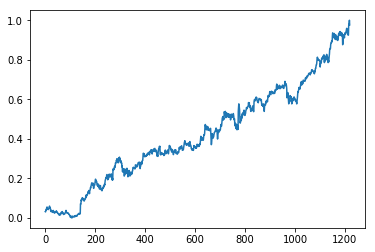

[[ 0.03192288]
 [ 0.03048322]
 [ 0.03668001]
 ..., 
 [ 0.98372555]
 [ 1.        ]
 [ 0.9765898 ]]


In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_stock_prices = scaler.fit_transform(yahoo_stock_prices)

plt.plot(yahoo_stock_prices)
plt.show()
print(yahoo_stock_prices)

In [25]:
train_size = int(len(yahoo_stock_prices) * 0.80)
test_size = len(yahoo_stock_prices) - train_size
train, test = yahoo_stock_prices[0:train_size,:], yahoo_stock_prices[train_size:len(yahoo_stock_prices),:]
print(len(train), len(test))

976 244


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), :]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :])
	return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, train.shape[1]))
testX = np.reshape(testX, (testX.shape[0], look_back, test.shape[1]))

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, number_of_stock)))
model.add(Dense(number_of_stock))
model.compile(loss='mse', optimizer='adam')
#Step 2 Build Model

In [30]:
from keras.callbacks import ModelCheckpoint
epochs = 300
batch_size = 1000

# model.load_weights('saved_models/weights.test_run')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.test_run.hdf5', 
                                   verbose=1, save_best_only=True)

model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size, validation_split=0.05, callbacks=[checkpointer])

/home/yicong/anaconda3/envs/Standard_ML_Dev/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 897 samples, validate on 48 samples
Epoch 1/300
Epoch 00000: val_loss improved from inf to 0.32145, saving model to saved_models/weights.test_run.hdf5
897/897 [==============================] - 0s - loss: 0.1151 - val_loss: 0.3214
Epoch 2/300
Epoch 00001: val_loss improved from 0.32145 to 0.28254, saving model to saved_models/weights.test_run.hdf5
897/897 [==============================] - 0s - loss: 0.1005 - val_loss: 0.2825
Epoch 3/300
Epoch 00002: val_loss improved from 0.28254 to 0.24591, saving model to saved_models/weights.test_run.hdf5
897/897 [==============================] - 0s - loss: 0.0869 - val_loss: 0.2459
Epoch 4/300
Epoch 00003: val_loss improved from 0.24591 to 0.21145, saving model to saved_models/weights.test_run.hdf5
897/897 [==============================] - 0s - loss: 0.0742 - val_loss: 0.2115
Epoch 5/300
Epoch 00004: val_loss improved from 0.21145 to 0.17912, saving model to saved_models/weights.test_run.hdf5
897/897 [==============================] - 0

897/897 [==============================] - 0s - loss: 2.8322e-04 - val_loss: 7.2217e-04
Epoch 112/300
Epoch 00111: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8285e-04 - val_loss: 7.3555e-04
Epoch 113/300
Epoch 00112: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8261e-04 - val_loss: 7.4476e-04
Epoch 114/300
Epoch 00113: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8242e-04 - val_loss: 7.4861e-04
Epoch 115/300
Epoch 00114: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8222e-04 - val_loss: 7.4658e-04
Epoch 116/300
Epoch 00115: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8193e-04 - val_loss: 7.3890e-04
Epoch 117/300
Epoch 00116: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.8155e-04 - val_loss: 7.2646e-04
Epoch 118/300
Epoch 00117: val_loss did not improve
897/897 [===========

897/897 [==============================] - 0s - loss: 2.6028e-04 - val_loss: 4.6668e-04
Epoch 228/300
Epoch 00227: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.6014e-04 - val_loss: 4.6558e-04
Epoch 229/300
Epoch 00228: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.6000e-04 - val_loss: 4.6450e-04
Epoch 230/300
Epoch 00229: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.5986e-04 - val_loss: 4.6343e-04
Epoch 231/300
Epoch 00230: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.5973e-04 - val_loss: 4.6238e-04
Epoch 232/300
Epoch 00231: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.5959e-04 - val_loss: 4.6134e-04
Epoch 233/300
Epoch 00232: val_loss did not improve
897/897 [==============================] - 0s - loss: 2.5945e-04 - val_loss: 4.6032e-04
Epoch 234/300
Epoch 00233: val_loss did not improve
897/897 [===========

In [31]:
# make predictions
model.load_weights('saved_models/weights.test_run.hdf5')
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [32]:
# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [34]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.84 RMSE
Test Score: 1.80 RMSE


In [35]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(yahoo_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(yahoo_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(yahoo_stock_prices)-1, :] = testPredict

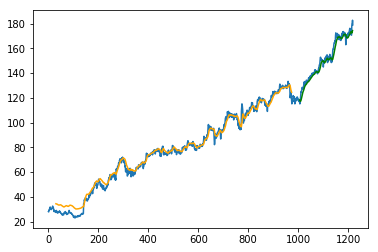

In [36]:
# plot baseline and predictions
ground_truth = scaler.inverse_transform(yahoo_stock_prices)
# plt.plot(scaler.inverse_transform(yahoo_stock_prices))
# print(yahoo_stock_prices.shape)
plt.plot(ground_truth[:,0])
plt.plot(trainPredictPlot[:,0], 'orange')
plt.plot(testPredictPlot[:,0],'green')
plt.show()

In [17]:
# # Predict = model.predict(yahoo_stock_prices)
# length_total = len(yahoo_stock_prices)
# day = 93
# test = yahoo_stock_prices[length_total-30-day:length_total-day].reshape(1,30,1)
# Predict = model.predict(test)
# print(scaler.inverse_transform(Predict))
# print(scaler.inverse_transform(yahoo_stock_prices[length_total-day].reshape(-1, 1)))